# Part I: Building a CNN 
In this part, you will build and evaluate a custom CNN model for image classification. You will work with a multi-class dataset to practice key aspects of building, training, and evaluating CNNs in PyTorch. Expected accuracy on the test dataset: > 85%.
The dataset consists of 36 categories and 2800 examples per category (100,800 total). Each image is 28x28.

## Step 1: Data preparation

1. Load the dataset using `ImageFolder` and prepare the dataloader.

In [ ]:

#Part-1
import os
import zipfile
import copy
import torch
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("The device using for training:",device)
zip_path,extract_dir="cnn_part_1_dataset.zip","cnn_part_1_dataset"
if not os.path.isdir(extract_dir):
    with zipfile.ZipFile(zip_path,'r') as z:
        z.extractall(extract_dir)
    print("Extracted to "+extract_dir+"/")

The device using for training: cuda
Extracted to cnn_part_1_dataset/


2. Analyze the dataset: brief description, key features, and statistics.

In [2]:
import os
print(os.listdir())
import torchvision.datasets as datasets
raw_ds=datasets.ImageFolder(extract_dir)
num_classes=len(raw_ds.classes)
total_samples=len(raw_ds)
class_counts={}
for cls in raw_ds.classes:
    class_counts[cls]=0

for image,label_index in raw_ds:
    class_name=raw_ds.classes[label_index]
    class_counts[class_name]+=1
first_image, _=raw_ds[0]
height, width = first_image.size[::-1]
img_shape=(height, width)

print("The total number of classes:", num_classes)
print("The total number of samples:", total_samples)
print("The image dimensions:", img_shape)
print("Samples per class:")
for cls,count in list(class_counts.items())[:5]:
    print(cls+":",count)





['.config', 'cnn_part_1_dataset', 'cnn_part_1_dataset.zip', 'sample_data']
The total number of classes: 1
The total number of samples: 100800
The image dimensions: (28, 28)
Samples per class:
cnn_dataset: 100800


<span style='color:green'>In this dataset contains grayscale 28×28 images of alphanumeric characters. Contains 36 classes of digits from 0-9 and uppercase letters A to Z</span>

3. Create three different visualizations to explore the dataset.

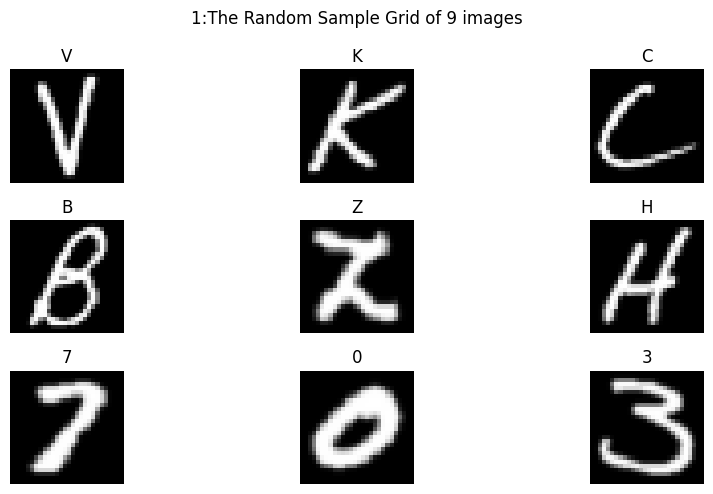

This grid depicts a random sample of 9 images which illustrating the variety of alphanumeric characters


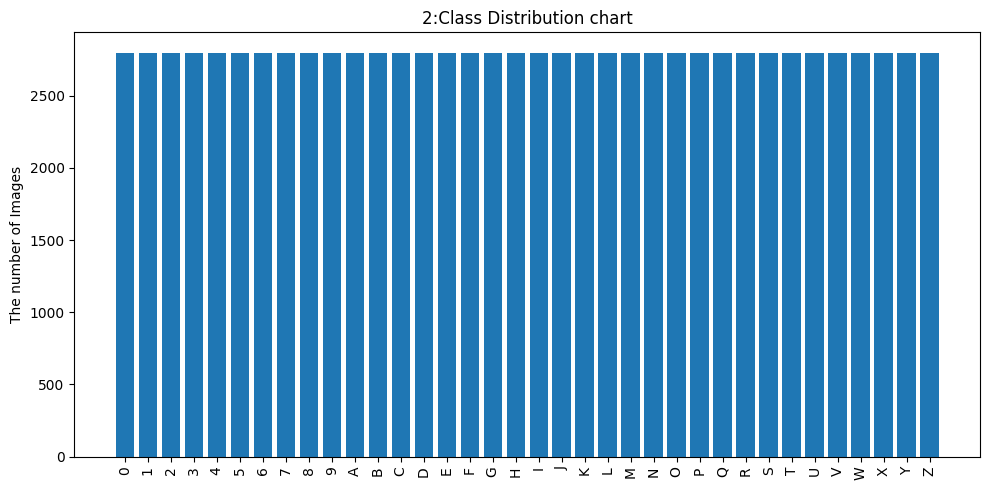

The bar chart shows the number of images per class


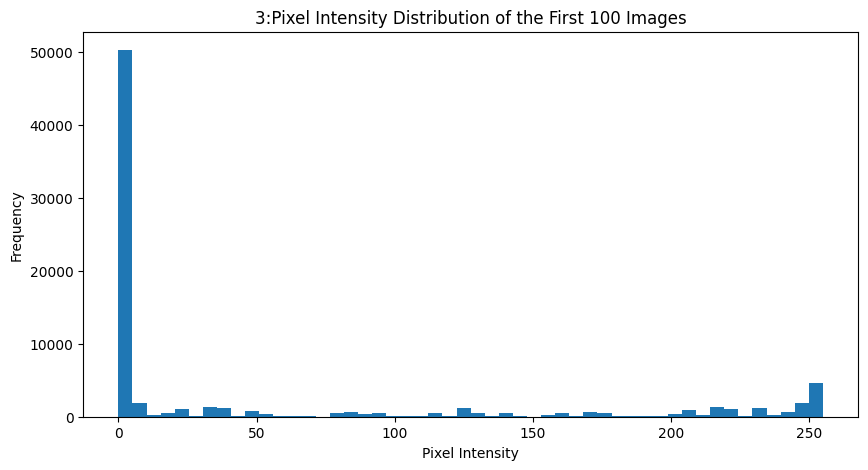

This histogram potrays pixel intensity distribution across sample images


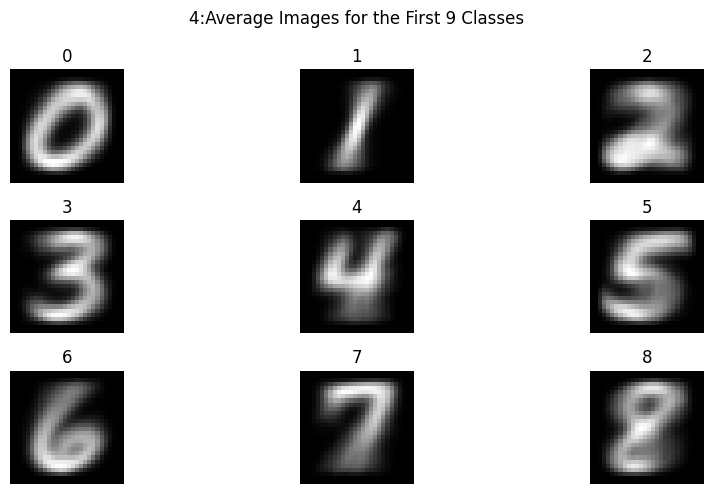

Average image for each class


In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def find_data_root(base):
    for root, dirs, _ in os.walk(base):
        subdir=[d for d in dirs if os.path.isdir(os.path.join(root, d))]
        if len(subdir)>1:
            return root
    return base
data_root=find_data_root(extract_dir)
classes=sorted(os.listdir(data_root))
filepaths=[]
labels=[]
for idx, cls in enumerate(classes):
    cls_folder=os.path.join(data_root, cls)
    for fname in os.listdir(cls_folder):
        filepaths.append(os.path.join(cls_folder, fname))
        labels.append(idx)
filepaths=np.array(filepaths)
labels=np.array(labels)
#1:The Random sample grid of 9 images
plt.figure(figsize=(10,5))
sample_idx=np.random.choice(len(filepaths),9, replace=False)
for i, idx in enumerate(sample_idx):
    img =Image.open(filepaths[idx]).convert('L')
    ax =plt.subplot(3,3,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(classes[labels[idx]])
    plt.axis('off')
plt.suptitle("1:The Random Sample Grid of 9 images")
plt.tight_layout()
plt.show()
print("This grid depicts a random sample of 9 images which illustrating the variety of alphanumeric characters")
#2:class distribution chart
counts={}
for cls in classes:
    counts[cls]=0
for cls in labels:
    counts[classes[cls]] +=1
plt.figure(figsize=(10,5))
plt.bar(counts.keys(),counts.values())
plt.xticks(rotation=90)
plt.ylabel("The number of Images")
plt.title("2:Class Distribution chart")
plt.tight_layout()
plt.show()
print("The bar chart shows the number of images per class")
#3:Pixel intensity histogram of the first 100 images
pixels = []
for path in filepaths[:100]:
    img=Image.open(path).convert('L')
    pixels.extend(np.array(img).flatten().tolist())
plt.figure(figsize=(10,5))
plt.hist(pixels,bins=50)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("3:Pixel Intensity Distribution of the First 100 Images")
plt.show()
print("This histogram potrays pixel intensity distribution across sample images")
#4:average image per class
avg_imgs = []
for idx,cls in enumerate(classes[:9]):
    cls_paths=filepaths[labels==idx]
    sum_img =np.zeros((28,28),dtype=np.float32)
    for p in cls_paths[:200]:
        img =np.array(Image.open(p).convert('L'),dtype=np.float32) / 255.0
        sum_img +=img
    avg_img =sum_img/min(len(cls_paths),200)
    avg_imgs.append(avg_img)
plt.figure(figsize=(10,5))
for i,img in enumerate(avg_imgs):
    ax =plt.subplot(3,3,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(classes[i])
    plt.axis('off')
plt.suptitle("4:Average Images for the First 9 Classes")
plt.tight_layout()
plt.show()
print("Average image for each class")

4. Preprocess the dataset (normalize, convert labels, address imbalance if needed).

In [5]:
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler, DataLoader
import torch.nn as nn
from torchvision import datasets
import torch
transform =transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),])
dataset =datasets.ImageFolder(data_root,transform=transform)
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

indices =np.arange(len(dataset))
train_idx,temp_idx, _,temp_labels=train_test_split(indices,dataset.targets,test_size=0.2,stratify=dataset.targets,random_state=42)

val_idx,test_idx, _, _ =train_test_split(temp_idx,temp_labels,test_size=0.5,stratify=temp_labels,random_state=42)



5. Split the dataset into training, validation, and test sets.

In [6]:
train_ds=Subset(dataset,train_idx)
val_ds=Subset(dataset,val_idx)
test_ds=Subset(dataset,test_idx)
train_loader=DataLoader(train_ds,batch_size=64,shuffle=True,num_workers=2)
val_loader=DataLoader(val_ds,batch_size=64,shuffle=False,num_workers=2)
test_loader=DataLoader(test_ds,batch_size=64,shuffle=False,num_workers=2)
print("Training samples:",len(train_ds))
print("Validation samples:",len(val_ds))
print("Testing samples:",len(test_ds))


Training samples: 80640
Validation samples: 10080
Testing samples: 10080


## Step 2: Implementing a basic CNN

1. Design a CNN architecture with ≤ 10 hidden layers for 36-class classification.

In [7]:
%pip install torchinfo
import torch
import torch.nn as nn
from torchinfo import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device for training:",device)
#Basic CNN Architecture
class BasicCNN(nn.Module):
    def __init__(self,num_classes=36):
        super(BasicCNN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x



using device for training: cuda


2. Display the model summary using `torchinfo.summary` or equivalent.

In [8]:
model =BasicCNN(num_classes=36).to(device)
summary(model,input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BasicCNN                                 [1, 36]                   --
├─Sequential: 1-1                        [1, 128, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 128, 7, 7]            73,856
│    └─ReLU: 2-8                         [1, 128, 7, 7]            --
│    └─MaxPool2d: 2-9                    [1, 128, 3, 3]            --
├─Sequential: 1-2                        [1, 36]                   --
│    └─Flatten: 2-10                     [1, 1152]                 --
│    └

## Step 3: Training and optimization

1. Train the CNN model.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=1e-3)
history={'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}
num_epochs=10
best_val_acc=0.0
best_state=model.state_dict()
for epoch in range(1,num_epochs+1):
    start=time.time()
    model.train()
    train_loss=0.0
    train_correct =0
    for X, y in train_loader:
        X,y=X.to(device),y.to(device)
        optimizer.zero_grad()
        out =model(X)
        loss =criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*X.size(0)
        train_correct+=(out.argmax(1)==y).sum().item()
    train_loss/=len(train_loader.dataset)
    train_acc=train_correct/len(train_loader.dataset)
    model.eval()
    val_loss=0.0
    val_correct=0
    with torch.no_grad():
        for X,y in val_loader:
            X,y=X.to(device),y.to(device)
            out=model(X)
            loss=criterion(out, y)
            val_loss+=loss.item()* X.size(0)
            val_correct+=(out.argmax(1)==y).sum().item()
    val_loss/=len(val_loader.dataset)
    val_acc=val_correct/len(val_loader.dataset)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    elapsed=time.time()-start
    print("Epoch{}/{} –Training Loss:{:.4f}Accuracy:{:.4f}–Validation Loss:{:.4f}Accuracy:{:.4f}–Time Taken:{:.1f}s".format(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc, elapsed))
    if val_acc >best_val_acc:
        best_val_acc =val_acc
        best_state=model.state_dict()
model.load_state_dict(best_state)
torch.save(model.state_dict(),'basic_cnn.pt')
print("Finished Training with best validation Accuracy:{:.4f}.Weights saved to basic_cnn.pt".format(best_val_acc))


Epoch1/10 –Training Loss:0.3371Accuracy:0.8796–Validation Loss:0.2559Accuracy:0.9006–Time Taken:27.2s
Epoch2/10 –Training Loss:0.2954Accuracy:0.8930–Validation Loss:0.2491Accuracy:0.9078–Time Taken:26.6s
Epoch3/10 –Training Loss:0.2728Accuracy:0.8982–Validation Loss:0.2433Accuracy:0.9102–Time Taken:28.5s
Epoch4/10 –Training Loss:0.2528Accuracy:0.9050–Validation Loss:0.2333Accuracy:0.9134–Time Taken:33.6s
Epoch5/10 –Training Loss:0.2369Accuracy:0.9102–Validation Loss:0.2355Accuracy:0.9116–Time Taken:27.2s
Epoch6/10 –Training Loss:0.2236Accuracy:0.9134–Validation Loss:0.2375Accuracy:0.9120–Time Taken:24.3s
Epoch7/10 –Training Loss:0.2138Accuracy:0.9158–Validation Loss:0.2362Accuracy:0.9155–Time Taken:29.9s
Epoch8/10 –Training Loss:0.2068Accuracy:0.9175–Validation Loss:0.2359Accuracy:0.9167–Time Taken:28.5s
Epoch9/10 –Training Loss:0.1961Accuracy:0.9220–Validation Loss:0.2399Accuracy:0.9155–Time Taken:27.7s
Epoch10/10 –Training Loss:0.1888Accuracy:0.9235–Validation Loss:0.2363Accuracy:0.9

2. Implement at least two improvement methods (dropout, data augmentation, etc.).

Improvement method #1

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.5)
num_epochs=20
best_val_acc=0.0
best_state=copy.deepcopy(model.state_dict())
history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
for epoch in range(1,num_epochs+1):
    start=time.time()
    model.train()
    train_loss=0.0
    train_correct=0
    for X,y in train_loader:
        X,y =X.to(device),y.to(device)
        optimizer.zero_grad()
        out=model(X)
        loss=criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*X.size(0)
        train_correct+=(out.argmax(1)==y).sum().item()
    train_loss/=len(train_loader.dataset)
    train_acc=train_correct/len(train_loader.dataset)
    model.eval()
    val_loss=0.0
    val_correct=0
    with torch.no_grad():
        for X,y in val_loader:
            X,y=X.to(device),y.to(device)
            out=model(X)
            loss=criterion(out, y)
            val_loss+=loss.item()*X.size(0)
            val_correct+=(out.argmax(1)==y).sum().item()
    val_loss/=len(val_loader.dataset)
    val_acc=val_correct/len(val_loader.dataset)
    scheduler.step()
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    elapsed =time.time()-start
    print("Epoch{}/{}-Training Loss:{:.4f}Accuracy:{:.4f}-Validation Loss:{:.4f} Accuracy:{:.4f}-Time:{:.1f}s".format(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc, elapsed))
    if val_acc >best_val_acc:
        best_val_acc=val_acc
        best_state=copy.deepcopy(model.state_dict())
model.load_state_dict(best_state)
torch.save(model.state_dict(), 'model_with_l2_&_scheduler.pt')
print("Training completed with Best validation Accuracy:{:.4f}".format(best_val_acc))




Epoch1/20-Training Loss:0.1900Accuracy:0.9240-Validation Loss:0.2309 Accuracy:0.9166-Time:22.3s
Epoch2/20-Training Loss:0.1884Accuracy:0.9237-Validation Loss:0.2437 Accuracy:0.9126-Time:25.7s
Epoch3/20-Training Loss:0.1858Accuracy:0.9241-Validation Loss:0.2268 Accuracy:0.9176-Time:23.2s
Epoch4/20-Training Loss:0.1847Accuracy:0.9256-Validation Loss:0.2360 Accuracy:0.9157-Time:33.9s
Epoch5/20-Training Loss:0.1812Accuracy:0.9263-Validation Loss:0.2288 Accuracy:0.9162-Time:31.4s
Epoch6/20-Training Loss:0.1564Accuracy:0.9346-Validation Loss:0.2280 Accuracy:0.9210-Time:28.0s
Epoch7/20-Training Loss:0.1491Accuracy:0.9373-Validation Loss:0.2318 Accuracy:0.9196-Time:29.1s
Epoch8/20-Training Loss:0.1449Accuracy:0.9381-Validation Loss:0.2328 Accuracy:0.9188-Time:27.0s
Epoch9/20-Training Loss:0.1435Accuracy:0.9392-Validation Loss:0.2308 Accuracy:0.9183-Time:23.4s
Epoch10/20-Training Loss:0.1406Accuracy:0.9407-Validation Loss:0.2380 Accuracy:0.9179-Time:23.2s
Epoch11/20-Training Loss:0.1272Accuracy

Improvement method #2

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
criterion=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.5)
num_epochs=20
best_val_acc=0.0
best_state=copy.deepcopy(model.state_dict())
history ={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
for epoch in range(1,num_epochs+1):
    start=time.time()
    model.train()
    running_loss=running_correct = 0
    for X,y in train_loader:
        X,y=X.to(device),y.to(device)
        optimizer.zero_grad()
        out=model(X)
        loss=criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()*X.size(0)
        running_correct+=(out.argmax(1)==y).sum().item()
    train_loss=running_loss/len(train_loader.dataset)
    train_acc=running_correct/len(train_loader.dataset)
    model.eval()
    val_loss=val_correct=0
    with torch.no_grad():
        for X,y in val_loader:
            X,y=X.to(device), y.to(device)
            out=model(X)
            loss=criterion(out, y)
            val_loss+=loss.item()* X.size(0)
            val_correct+=(out.argmax(1)==y).sum().item()
    val_loss=val_loss/len(val_loader.dataset)
    val_acc=val_correct/len(val_loader.dataset)
    scheduler.step()
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    elapsed=time.time() - start
    print("Epoch{}/{}-Training Loss:{:.4f}Acc:{:.4f}-Validation Loss:{:.4f}Acc:{:.4f}-Time:{:.1f}s".format(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc, elapsed))
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        best_state=copy.deepcopy(model.state_dict())
model.load_state_dict(best_state)
torch.save(model.state_dict(),'model_with_AdamW_and_LR.pt')
print("Training finished with Best validation Acc:{:.4f}".format(best_val_acc))



Epoch1/20-Training Loss:0.1628Acc:0.9313-Validation Loss:0.2457Acc:0.9141-Time:23.6s
Epoch2/20-Training Loss:0.1594Acc:0.9333-Validation Loss:0.2483Acc:0.9142-Time:23.1s
Epoch3/20-Training Loss:0.1551Acc:0.9354-Validation Loss:0.2505Acc:0.9172-Time:23.2s
Epoch4/20-Training Loss:0.1534Acc:0.9356-Validation Loss:0.2713Acc:0.9137-Time:23.1s
Epoch5/20-Training Loss:0.1480Acc:0.9372-Validation Loss:0.2659Acc:0.9167-Time:22.4s
Epoch6/20-Training Loss:0.1222Acc:0.9469-Validation Loss:0.2656Acc:0.9173-Time:23.6s
Epoch7/20-Training Loss:0.1134Acc:0.9501-Validation Loss:0.2761Acc:0.9186-Time:23.1s
Epoch8/20-Training Loss:0.1091Acc:0.9522-Validation Loss:0.2897Acc:0.9163-Time:23.3s
Epoch9/20-Training Loss:0.1057Acc:0.9528-Validation Loss:0.2960Acc:0.9172-Time:23.2s
Epoch10/20-Training Loss:0.1017Acc:0.9559-Validation Loss:0.2953Acc:0.9192-Time:23.7s
Epoch11/20-Training Loss:0.0904Acc:0.9603-Validation Loss:0.3154Acc:0.9179-Time:22.8s
Epoch12/20-Training Loss:0.0858Acc:0.9631-Validation Loss:0.328

Shape of a batch after transformations and explicit conversion: torch.Size([64, 1, 28, 28])

Training with SGD
Epoch1/10-Training Loss:1.3164Accuracy:0.6047-Validation Loss:0.3840Accuracy:0.8689-Time:23.0s
Epoch2/10-Training Loss:0.4772Accuracy:0.8353-Validation Loss:0.2974Accuracy:0.8947-Time:23.1s
Epoch3/10-Training Loss:0.3908Accuracy:0.8602-Validation Loss:0.2804Accuracy:0.8989-Time:21.8s
Epoch4/10-Training Loss:0.3497Accuracy:0.8751-Validation Loss:0.2517Accuracy:0.9001-Time:23.0s
Epoch5/10-Training Loss:0.3269Accuracy:0.8808-Validation Loss:0.2476Accuracy:0.9052-Time:22.9s
Epoch6/10-Training Loss:0.2828Accuracy:0.8949-Validation Loss:0.2279Accuracy:0.9121-Time:22.7s
Epoch7/10-Training Loss:0.2734Accuracy:0.8989-Validation Loss:0.2270Accuracy:0.9153-Time:22.7s
Epoch8/10-Training Loss:0.2680Accuracy:0.8996-Validation Loss:0.2224Accuracy:0.9127-Time:22.2s
Epoch9/10-Training Loss:0.2602Accuracy:0.9024-Validation Loss:0.2216Accuracy:0.9157-Time:22.7s
Epoch10/10-Training Loss:0.2527Acc

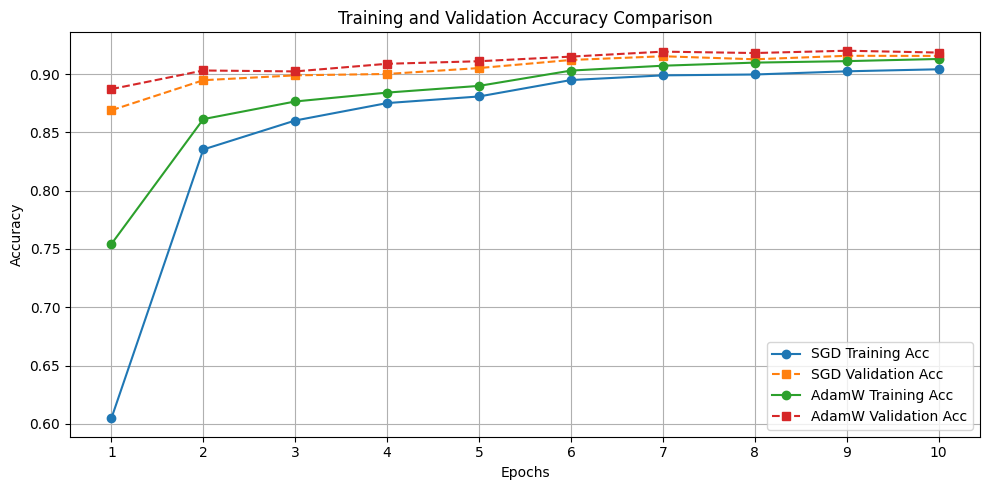

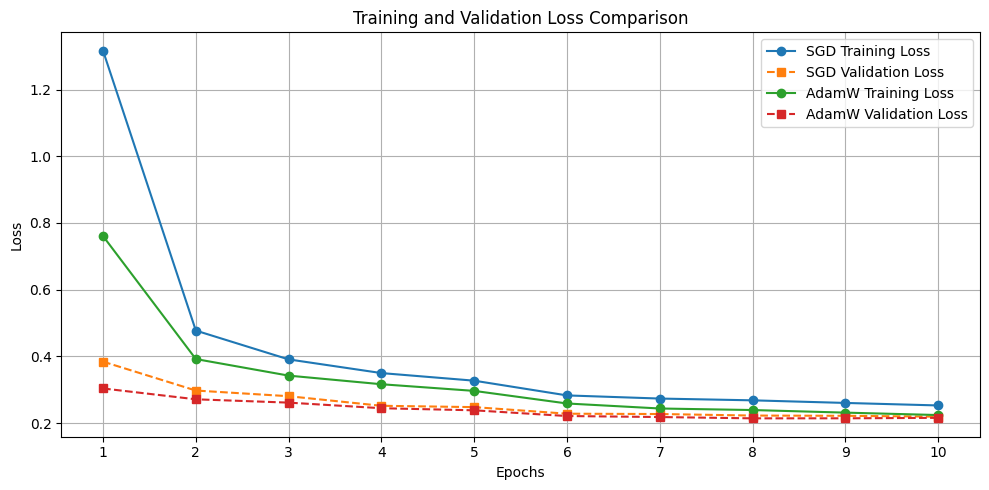

In [13]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
import matplotlib.pyplot as plt
class ImprovedCNN(nn.Module):
    def __init__(self,num_classes):
        super(ImprovedCNN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*3*3,512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )

    def forward(self,x):
        x=self.features(x)
        x=torch.flatten(x, 1)
        x=self.classifier(x)
        return x


def train_model(model,optimizer,scheduler,num_epochs=10,patience=3):
    criterion=nn.CrossEntropyLoss()
    best_val_acc=0.0
    best_state=copy.deepcopy(model.state_dict())
    history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    epochs_without_improvement=0
    for epoch in range(1,num_epochs + 1):
        start=time.time()
        model.train()
        train_loss=0.0
        train_correct=0
        for X, y in train_loader:
            X,y=X.to(device),y.to(device)
            if X.shape[1]==1:
                X=X.repeat(1,3,1,1)
            optimizer.zero_grad()
            out=model(X)
            loss=criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()*X.size(0)
            train_correct+=(out.argmax(1)==y).sum().item()
        train_loss/=len(train_loader.dataset)
        train_acc=train_correct/ len(train_loader.dataset)
        model.eval()
        val_loss=0.0
        val_correct=0
        with torch.no_grad():
            for X, y in val_loader:
                X,y=X.to(device),y.to(device)
                if X.shape[1]==1:
                    X=X.repeat(1, 3, 1, 1)
                out =model(X)
                loss =criterion(out, y)
                val_loss +=loss.item()*X.size(0)
                val_correct +=(out.argmax(1)==y).sum().item()
        val_loss/=len(val_loader.dataset)
        val_acc=val_correct/len(val_loader.dataset)
        scheduler.step()
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        elapsed=time.time() - start
        print("Epoch{}/{}-Training Loss:{:.4f}Accuracy:{:.4f}-Validation Loss:{:.4f}Accuracy:{:.4f}-Time:{:.1f}s".format(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc, elapsed))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("early stopping after {} epochs without improvement.".format(patience))
                break
    model.load_state_dict(best_state)
    return model, history


transform=transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
full_ds=datasets.ImageFolder(data_root,transform=transform)
num_classes=len(full_ds.classes)
for X, y in train_loader:
    print("Shape of a batch after transformations and explicit conversion:", X.shape)
    break
optimizers={
    'SGD':lambda params: torch.optim.SGD(params,lr=0.01,momentum=0.9,weight_decay=1e-4),
    'AdamW':lambda params: torch.optim.AdamW(params,lr=1e-3,weight_decay=1e-4)
}
results={}
for name,opt_fn in optimizers.items():
    print("\nTraining with {}".format(name))
    model=ImprovedCNN(num_classes).to(device)
    optimizer=opt_fn(model.parameters())
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.5)
    _, history = train_model(model,optimizer,scheduler,num_epochs=10,patience=3)
    results[name]=history
epochs=range(1,len(next(iter(results.values()))['train_loss']) + 1)
plt.figure(figsize=(10,5))
for name, hist in results.items():
    plt.plot(epochs,hist['train_acc'],marker='o',label=f'{name} Training Acc')
    plt.plot(epochs,hist['val_acc'],marker='s',linestyle='--',label=f'{name} Validation Acc')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 5))
for name, hist in results.items():
    plt.plot(epochs,hist['train_loss'],marker='o',label=f'{name} Training Loss')
    plt.plot(epochs,hist['val_loss'],marker='s',linestyle='--',label=f'{name} Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3. Compare results using two different optimizers.

4. Discuss optimizer performance and effect of training improvements.

<span style='color:green'>AdamW decisively outpaces vanilla SGD on this task: it leaps to a higher validation accuracy in the very first epoch itself (88.6 % vs. 86.8 %) and never relinquishes the lead, ending at around 92 % compared to SGD's 91.5 %. Including L2 weight decay stopped both optimizers from overfitting, and the StepLR schedule—reducing the learning rate by half midway—allowed the models to fine‐tune more subtly, smoothing out losses and validation accuracy higher. In practice, AdamW's adaptive moment estimates + decoupled weight decay yield faster convergence and slightly better generalization than SGD under these training tweaks.
</span>

5. Save the best-performing model weights.

In [14]:
torch.save(model.state_dict(),'model_with_AdamW_and_LR.pt')

## Step 4: Evaluation and analysis

1. Report training/validation/testing metrics and analyze the results

In [15]:
model.eval()
test_loss=0.0
test_correct=0
all_labels=[]
all_preds=[]
with torch.no_grad():
    for X,y in test_loader:
        X,y=X.to(device),y.to(device)
        if X.shape[1]==1:
            X=X.repeat(1, 3, 1, 1)
        out=model(X)
        loss=criterion(out, y)
        test_loss+=loss.item()* X.size(0)
        preds=out.argmax(dim=1)
        test_correct+=(preds==y).sum().item()
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss/=len(test_loader.dataset)
test_acc=test_correct/len(test_loader.dataset)
print("Testing Loss: {:.4f}".format(test_loss))
print("Testing Accuracy: {:.4f}".format(test_acc))


Testing Loss: 0.2075
Testing Accuracy: 0.9206


2. Plot accuracy and loss over epochs.

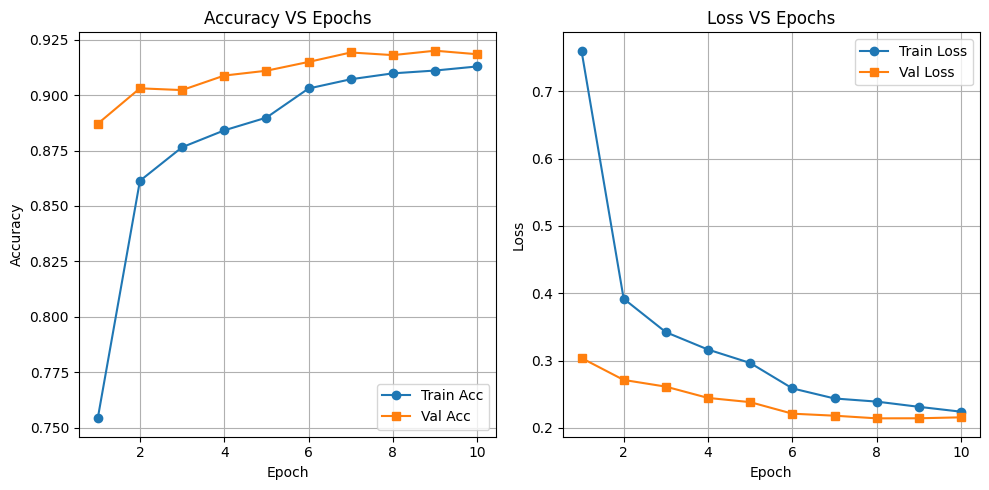

In [16]:
epochs=range(1,len(history['train_loss'])+1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,history['train_acc'],marker='o',label='Train Acc')
plt.plot(epochs,history['val_acc'],marker='s',label='Val Acc')
plt.title('Accuracy VS Epochs')
plt.xlabel('Epoch');plt.ylabel('Accuracy');plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs,history['train_loss'],marker='o',label='Train Loss')
plt.plot(epochs,history['val_loss'],marker='s',label='Val Loss')
plt.title('Loss VS Epochs')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3. Generate and analyze confusion matrix.

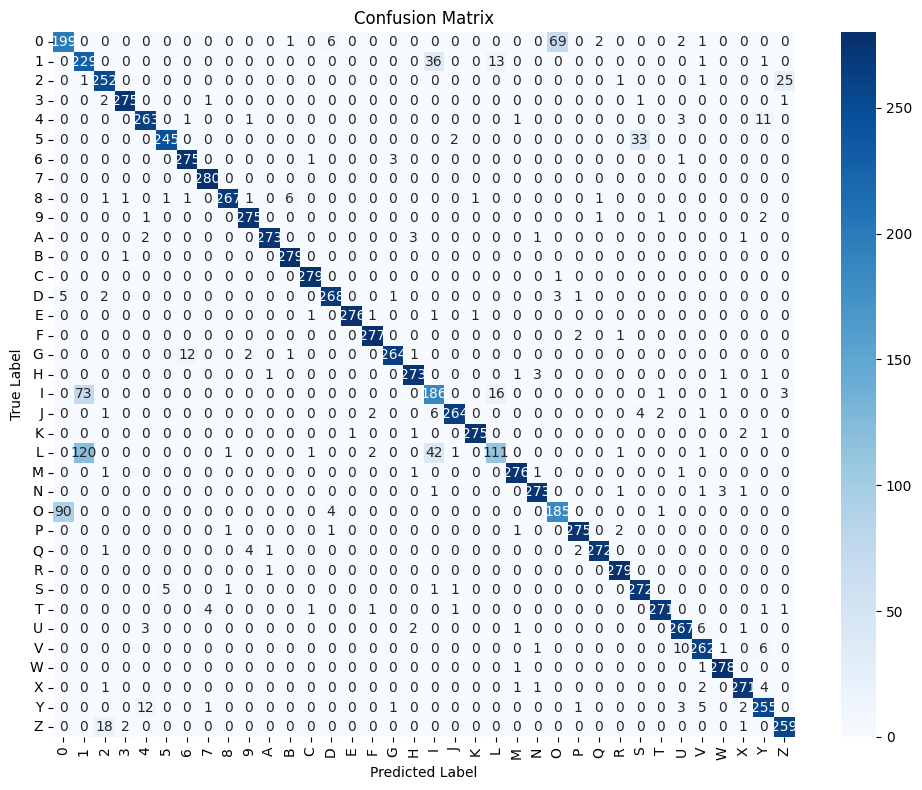

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=full_ds.classes,yticklabels=full_ds.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

4. Compute and analyze precision, recall, F1 scores.

In [18]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds,target_names=full_ds.classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       280
           1       0.54      0.82      0.65       280
           2       0.90      0.90      0.90       280
           3       0.99      0.98      0.98       280
           4       0.94      0.94      0.94       280
           5       0.98      0.88      0.92       280
           6       0.95      0.98      0.97       280
           7       0.98      1.00      0.99       280
           8       0.99      0.95      0.97       280
           9       0.97      0.98      0.98       280
           A       0.99      0.97      0.98       280
           B       0.97      1.00      0.98       280
           C       0.99      1.00      0.99       280
           D       0.96      0.96      0.96       280
           E       1.00      0.99      0.99       280
           F       0.98      0.99      0.98       280
           G       0.98      0.94      0.96       280
    

6. Display and analyze a few misclassified images.

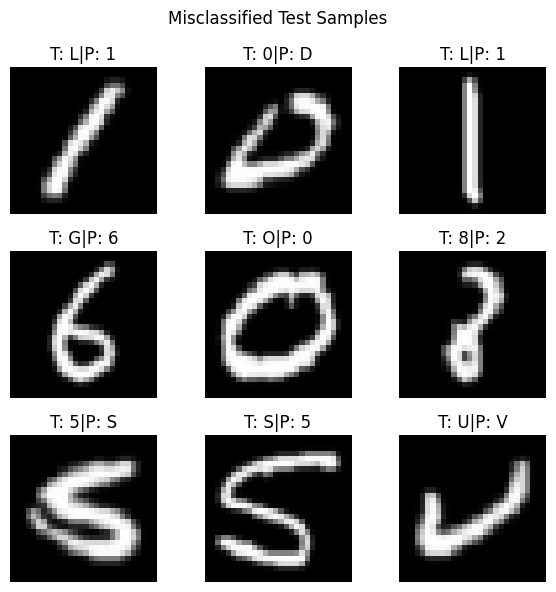

In [19]:
mis_indices=np.where(np.array(all_labels)!=np.array(all_preds))[0]
num_show=min(9,len(mis_indices))
fig,axes=plt.subplots(3,3,figsize=(6,6))
for i, idx in enumerate(np.random.choice(mis_indices,num_show,replace=False)):
    img,true_lbl=test_ds[idx]
    pred_lbl=all_preds[idx]
    ax=axes[i//3,i%3]
    ax.imshow(img.squeeze(),cmap='gray')
    ax.set_title(f"T: {full_ds.classes[true_lbl]}|P: {full_ds.classes[pred_lbl]}")
    ax.axis('off')
plt.suptitle('Misclassified Test Samples')
plt.tight_layout()
plt.show()

## References

<span style='color:green'>https://scikit-learn.org/ and
https://docs.pytorch.org/


</span>